In [118]:
from data_pipeline.modular_data_extraction import create_data_packages
from data_pipeline.np_dataset import NpDataset
import input_mapping.models_torch as models_torch
from data_pipeline.image_transforms import get_transforms
from data_pipeline.ukb_data_extractor import UkbDataExtractor
import data_pipeline.data_processing_utils as dpu

from PIL import Image
from pydicom import dcmread
import torch
from torch.utils.data import DataLoader, Dataset, ConcatDataset
from torchvision import transforms
import numpy as np

from convert_user_inputs import convert_user_input, create_datasets
from ai_backend.loggers.model_logger import is_min
from uuid import uuid4
import torch.nn as nn
from torch.optim import Adam
import torch
import json
from datetime import datetime
import os
import re
import tqdm
from ai_backend.evaluators.metrics.multi_label_metrics import  multi_label_f_beta, multi_label_confusion_matrix, multi_label_accuracy, multi_label_precision, multi_label_recal
import numpy as np
from sklearn.metrics import ConfusionMatrixDisplay, multilabel_confusion_matrix
import matplotlib.pyplot as plt


In [119]:
model_key = 'resnet18'
transform_type = 'ben'
batch_size = 16
lr = 0.00004614948033730265
epochs = 30
dataset_name = '2024-02-23-13-31-39'
dataset_path = f'datasets/{dataset_name}'

In [120]:
labels_to_encode = np.array(["Age-related Macular Degeneration", "Best Disease", "Bietti crystalline dystrophy",
                              "cataract", "Cone Dystrophie or Cone-rod Dystrophie", "Diabetic Retinopathy",
                              "glaucoma", "Maculopathy", "Myopia", "Normal", "Retinitis Pigmentosa", "Stargardt Disease"])

In [121]:
model_key = 'resnet18'
transform_type = 'ben'
transforms_config = models_torch.model_dict[model_key]['transforms_config']
transform = get_transforms(transform_name = transform_type, transforms_config = transforms_config)

In [122]:
ukb_database_path = '/home/efarjall/ird_dataset/IRD-Dataset-Complete-03-anonymized.xlsx'
ukb_data_path ='/home/efarjall/ird_dataset/export_heyex_original_dataset_03/DICOM'
ukb_extractor = UkbDataExtractor(database_path=ukb_data_path, label_path=ukb_database_path)


array([['0001',
        '/home/efarjall/ird_dataset/export_heyex_original_dataset_03/DICOM/0001/100062/506240/9020098/00000000',
        'Morbus Stargardt'],
       ['0001',
        '/home/efarjall/ird_dataset/export_heyex_original_dataset_03/DICOM/0001/100062/506240/9020099/00000001',
        'Morbus Stargardt'],
       ['0002',
        '/home/efarjall/ird_dataset/export_heyex_original_dataset_03/DICOM/0002/94654/472214/8601390/00000000',
        'Morbus Stargardt'],
       ...,
       ['0998',
        '/home/efarjall/ird_dataset/export_heyex_original_dataset_03/DICOM/0998/98368/495330/8888520/00000001',
        'Optikusatrophie'],
       ['0999',
        '/home/efarjall/ird_dataset/export_heyex_original_dataset_03/DICOM/0999/97968/492965/8857989/00000000',
        'Optikusatrophie'],
       ['0999',
        '/home/efarjall/ird_dataset/export_heyex_original_dataset_03/DICOM/0999/97968/492965/8857990/00000001',
        'Optikusatrophie']], dtype='<U102')

In [123]:
#split the data stratified by the labels
train_portion = 0.7
val_portion = 0.1
test_portion = 0.2
split_portions = [train_portion, val_portion, test_portion]

In [124]:
label_mapping_dict = {'Morbus Best': 'Best Disease', 'Morbus Stargardt': 'Stargardt Disease', 'Retinitis pigmentosa': 'Retinitis Pigmentosa'}
splits = ukb_extractor.split_extracted_data(split_portions=split_portions, stratify=True)
# create data packages
train_package = splits[0]
val_package = splits[1]
test_package = splits[2]


In [125]:
#map the labels
for split in splits:
    #strip trailing and leading whitespaces
    split.labels = np.vectorize(str.strip)(split.labels)
    split.labels = np.vectorize(label_mapping_dict.get)(split.labels)


In [126]:
label_encoder = dpu.create_one_hot_encoder(unique_labels=labels_to_encode)

In [127]:
for split in splits:
    split.labels = dpu.encode_multistring_labels(split.labels, label_encoder)

In [128]:
#find out which datapoints have a full 0 label
for split in splits:
    labels = split.get_labels()
    no_zero_labels = np.sum(labels, axis=1) != 0
    #print len false values
    print('n filtered', len(no_zero_labels) - np.sum(no_zero_labels))
    #throw away the datapoints with no labels
    split.labels = labels[no_zero_labels]
    split.data = split.data[no_zero_labels]


n filtered 716
n filtered 112
n filtered 213


In [129]:
#create np datasets for training, validation and testing
read_dicom = lambda x: dcmread(x).pixel_array
file_reader = lambda x: Image.fromarray(read_dicom(x)).convert('RGB')
train_dataset = NpDataset(file_paths=splits[0].get_data()[:,1], labels=splits[0].get_labels(), file_reader=file_reader, transform=transform)
val_dataset = NpDataset(file_paths=splits[1].get_data()[:,1], labels=splits[1].get_labels(), file_reader=file_reader, transform=transform)
test_dataset = NpDataset(file_paths=splits[2].get_data()[:,1], labels=splits[2].get_labels(), file_reader=file_reader, transform=transform)

In [130]:

#read in json file with the label columns
dataset_config_path  = f'{dataset_path}/dataset_config.json'
train_dataset_path = f'{dataset_path}/All_train.csv'
validation_dataset_path = f'{dataset_path}/All_validation.csv'
test_dataset_path = f'{dataset_path}/All_test.csv'
with open(dataset_config_path) as json_file:
    dataset_config = json.load(json_file)
label_cols = dataset_config['label_names']
path_to_img_column = dataset_config['path_to_img_column']
#read wandb config

#initialize wand
base_train_dataset, base_validation_dataset, base_test_dataset = create_datasets(model_key = model_key, transform_type = transform_type,train_dataset_path = train_dataset_path,
                                                                   validation_dataset_path = validation_dataset_path,
                                                                   test_dataset_path = test_dataset_path, path_to_img_column = path_to_img_column,
                                                                     label_cols = label_cols, augmentation = True, shuffle = True)


In [131]:
#concat the datasets
train_dataset = ConcatDataset([base_train_dataset, train_dataset])
validation_dataset = ConcatDataset([base_validation_dataset, val_dataset])
test_dataset = ConcatDataset([base_test_dataset, test_dataset])

#create data loaders
num_workers = 8
train_loader = DataLoader(train_dataset, batch_size=batch_size, num_workers=num_workers, shuffle=True)
validation_loader = DataLoader(validation_dataset, batch_size=batch_size, num_workers=num_workers)
test_loader = DataLoader(test_dataset, batch_size=batch_size, num_workers=num_workers)

In [132]:
print(len(train_dataset), len(validation_dataset), len(test_dataset))
print(len(base_train_dataset), len(base_validation_dataset), len(base_test_dataset))

2424 100 629
1663 211 420


In [133]:
#train the model
best_model_save_folder = f'best_models_for_dataset/{dataset_name}/{model_key}/best_model_{transform_type}'
best_model_save_path = f'{best_model_save_folder}/best_model.pt'

In [134]:
# create model
model = models_torch.get_model(model_name=model_key, num_classes=len(labels_to_encode))
#load the model weights
dataset_name = '2024-02-23-13-31-39'
#model.load_state_dict(torch.load(best_model_save_path))


/home/efarjall/miniconda3/envs/ird/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/efarjall/miniconda3/envs/ird/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


In [135]:
criterion = nn.BCEWithLogitsLoss()
optimizer = Adam(model.parameters(), lr=lr)

In [136]:
# Freeze only the convolutional layers of the pre-trained model
for param in model.parameters():
    if isinstance(param, nn.Conv2d):
        param.requires_grad = False

In [137]:
#add dropout forward hooks to the model
for name, module in model.named_modules():
    re_pattern = re.compile(r'^layer\d+$')
    if re_pattern.match(name) is not None:
        print('Adding forward hook for:', name)
        module.register_forward_hook(lambda module, input,
                                      output: torch.nn.functional.dropout2d(output, p=0.2, training=module.training))

Adding forward hook for: layer1
Adding forward hook for: layer2
Adding forward hook for: layer3
Adding forward hook for: layer4


In [138]:
#train the model
best_model_save_folder = f'ukb_fine_tuned_models/{dataset_name}/{model_key}/best_model_{transform_type}'
best_model_save_path = f'{best_model_save_folder}/best_model.pt'
os.makedirs(best_model_save_folder, exist_ok=True)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
progress_bar = tqdm.tqdm(range(epochs))
validation_loss_criterion = nn.BCEWithLogitsLoss()
validation_losses = []
best_validation_loss = np.inf
#move the model to the device
model.to(device)
#only run training if no model has been saved yet
if not os.path.exists(best_model_save_path):
    for epoch in progress_bar:
        model.train()
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

        model.eval()
        with torch.no_grad():
            validaton_outputs = []
            validaton_labels = []
            for inputs, labels in validation_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                validaton_outputs.append(outputs)
                validaton_labels.append(labels)
            #concatenate the outputs and labels
            validaton_outputs = torch.cat(validaton_outputs, dim=0)
            validaton_labels = torch.cat(validaton_labels, dim=0)
            loss_validation = validation_loss_criterion(validaton_outputs, validaton_labels).item()
            if is_min(loss_validation, best_validation_loss):
                best_validation_loss = loss_validation
                torch.save(model.state_dict(), best_model_save_path)
            validation_losses.append(loss_validation)
            #update the progress bar
            progress_bar.set_postfix({'Loss validation': loss_validation, 'best validation loss': min(validation_losses)})
        

  0%|          | 0/30 [00:35<?, ?it/s]


FileNotFoundError: Caught FileNotFoundError in DataLoader worker process 0.
Original Traceback (most recent call last):
  File "/home/efarjall/miniconda3/envs/ird/lib/python3.11/site-packages/torch/utils/data/_utils/worker.py", line 308, in _worker_loop
    data = fetcher.fetch(index)
           ^^^^^^^^^^^^^^^^^^^^
  File "/home/efarjall/miniconda3/envs/ird/lib/python3.11/site-packages/torch/utils/data/_utils/fetch.py", line 51, in fetch
    data = [self.dataset[idx] for idx in possibly_batched_index]
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/efarjall/miniconda3/envs/ird/lib/python3.11/site-packages/torch/utils/data/_utils/fetch.py", line 51, in <listcomp>
    data = [self.dataset[idx] for idx in possibly_batched_index]
            ~~~~~~~~~~~~^^^^^
  File "/home/efarjall/miniconda3/envs/ird/lib/python3.11/site-packages/torch/utils/data/dataset.py", line 335, in __getitem__
    return self.datasets[dataset_idx][sample_idx]
           ~~~~~~~~~~~~~~~~~~~~~~~~~~^^^^^^^^^^^^
  File "/home/efarjall/IRD-DeepLearning/data_pipeline/data_loading.py", line 41, in __getitem__
    img = Image.open(row[self.data_path_col]).convert('RGB')
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/efarjall/miniconda3/envs/ird/lib/python3.11/site-packages/PIL/Image.py", line 3247, in open
    fp = builtins.open(filename, "rb")
         ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
FileNotFoundError: [Errno 2] No such file or directory: 'databases/RFMiD2_0/Validation_set/632.jpg'


In [ ]:
#load the best model
model.load_state_dict(torch.load(best_model_save_path))

<All keys matched successfully>

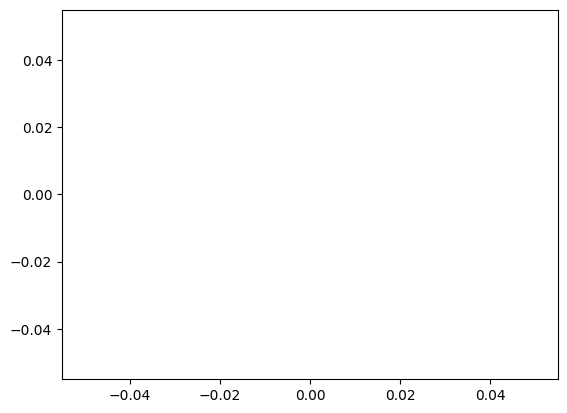

In [ ]:
plt.plot(validation_losses)

In [ ]:
#todo check why one is 3, 224, 224 and the other is 224, 224, 3
for data, label in base_validation_dataset:
    print(data.shape)
    break

for data, label in val_dataset:
    print(data.shape)
    break

torch.Size([3, 224, 224])
torch.Size([3, 224, 224])


In [ ]:
#get the predictions for the model
y_true_validation = []
y_pred_validation = []
model.to(device)
model.eval()
with torch.no_grad():
    for inputs, labels in validation_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)
        outputs = model(inputs)
        y_true_validation.append(labels.detach().clone())
        y_pred_validation.append(outputs.detach().clone())
y_true_validation = torch.cat(y_true_validation, dim=0).cpu()
y_pred_validation = torch.cat(y_pred_validation, dim=0).cpu()

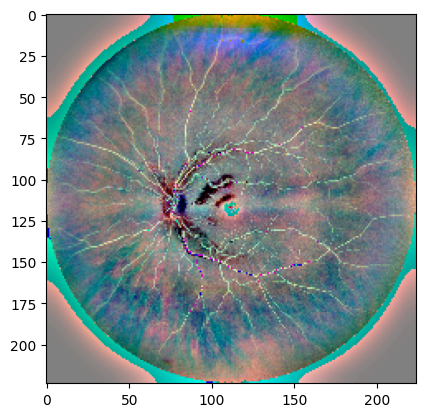

In [ ]:
import random
from torchvision.transforms.functional import to_pil_image
for data, label in val_dataset:
    #plot the image
    if random.random() < 0.5:
        plt.imshow(to_pil_image(data))
        plt.show()
        break

In [ ]:
#find the best threshold for each label
#turn off optuna warnings
step_size = 0.01
iterations = 1/step_size
#set the verbosity to error

best_thresholds = []

for i in range(len(labels_to_encode)):
    best_thresholds.append(0)
    best_score = 0
    #todo fix the max function
    for j in range(int(iterations)):
        threshold = j*step_size
        f1_score = multi_label_f_beta(y_true_validation, y_pred_validation, beta=1.0, averaging_type=None, threshold=threshold)
        if f1_score[i] > best_score:
            best_score = f1_score[i]
            best_thresholds[i] = threshold
    print('Best thresholds found for class', labels_to_encode[i], 'at', best_thresholds[i], 'with a score of', best_score)
#save the best thresholds
model_config = {
    'best_thresholds': best_thresholds
}

best_thresholds = torch.Tensor(best_thresholds)



/home/efarjall/IRD-DeepLearning/ai_backend/evaluators/metrics/multi_label_metrics.py:174: RuntimeWarning: invalid value encountered in divide
  f_beta = (1 + beta**2) * (precision * recal) / ((beta**2 * precision) + recal)
/home/efarjall/IRD-DeepLearning/ai_backend/evaluators/metrics/multi_label_metrics.py:174: RuntimeWarning: invalid value encountered in divide
  f_beta = (1 + beta**2) * (precision * recal) / ((beta**2 * precision) + recal)
/home/efarjall/IRD-DeepLearning/ai_backend/evaluators/metrics/multi_label_metrics.py:174: RuntimeWarning: invalid value encountered in divide
  f_beta = (1 + beta**2) * (precision * recal) / ((beta**2 * precision) + recal)
/home/efarjall/IRD-DeepLearning/ai_backend/evaluators/metrics/multi_label_metrics.py:174: RuntimeWarning: invalid value encountered in divide
  f_beta = (1 + beta**2) * (precision * recal) / ((beta**2 * precision) + recal)
/home/efarjall/IRD-DeepLearning/ai_backend/evaluators/metrics/multi_label_metrics.py:174: RuntimeWarning: in

Best thresholds found for class Age-related Macular Degeneration at 0.3 with a score of 0.2279411764705882
Best thresholds found for class Best Disease at 0.3 with a score of 0.05


/home/efarjall/IRD-DeepLearning/ai_backend/evaluators/metrics/multi_label_metrics.py:174: RuntimeWarning: invalid value encountered in divide
  f_beta = (1 + beta**2) * (precision * recal) / ((beta**2 * precision) + recal)
/home/efarjall/IRD-DeepLearning/ai_backend/evaluators/metrics/multi_label_metrics.py:174: RuntimeWarning: invalid value encountered in divide
  f_beta = (1 + beta**2) * (precision * recal) / ((beta**2 * precision) + recal)
/home/efarjall/IRD-DeepLearning/ai_backend/evaluators/metrics/multi_label_metrics.py:174: RuntimeWarning: invalid value encountered in divide
  f_beta = (1 + beta**2) * (precision * recal) / ((beta**2 * precision) + recal)
/home/efarjall/IRD-DeepLearning/ai_backend/evaluators/metrics/multi_label_metrics.py:174: RuntimeWarning: invalid value encountered in divide
  f_beta = (1 + beta**2) * (precision * recal) / ((beta**2 * precision) + recal)
/home/efarjall/IRD-DeepLearning/ai_backend/evaluators/metrics/multi_label_metrics.py:174: RuntimeWarning: in

Best thresholds found for class Bietti crystalline dystrophy at 0.49 with a score of 0.006968641114982578


/home/efarjall/IRD-DeepLearning/ai_backend/evaluators/metrics/multi_label_metrics.py:174: RuntimeWarning: invalid value encountered in divide
  f_beta = (1 + beta**2) * (precision * recal) / ((beta**2 * precision) + recal)
/home/efarjall/IRD-DeepLearning/ai_backend/evaluators/metrics/multi_label_metrics.py:174: RuntimeWarning: invalid value encountered in divide
  f_beta = (1 + beta**2) * (precision * recal) / ((beta**2 * precision) + recal)
/home/efarjall/IRD-DeepLearning/ai_backend/evaluators/metrics/multi_label_metrics.py:174: RuntimeWarning: invalid value encountered in divide
  f_beta = (1 + beta**2) * (precision * recal) / ((beta**2 * precision) + recal)
/home/efarjall/IRD-DeepLearning/ai_backend/evaluators/metrics/multi_label_metrics.py:174: RuntimeWarning: invalid value encountered in divide
  f_beta = (1 + beta**2) * (precision * recal) / ((beta**2 * precision) + recal)
/home/efarjall/IRD-DeepLearning/ai_backend/evaluators/metrics/multi_label_metrics.py:174: RuntimeWarning: in

Best thresholds found for class cataract at 0.44 with a score of 0.2396694214876033


/home/efarjall/IRD-DeepLearning/ai_backend/evaluators/metrics/multi_label_metrics.py:174: RuntimeWarning: invalid value encountered in divide
  f_beta = (1 + beta**2) * (precision * recal) / ((beta**2 * precision) + recal)
/home/efarjall/IRD-DeepLearning/ai_backend/evaluators/metrics/multi_label_metrics.py:174: RuntimeWarning: invalid value encountered in divide
  f_beta = (1 + beta**2) * (precision * recal) / ((beta**2 * precision) + recal)
/home/efarjall/IRD-DeepLearning/ai_backend/evaluators/metrics/multi_label_metrics.py:174: RuntimeWarning: invalid value encountered in divide
  f_beta = (1 + beta**2) * (precision * recal) / ((beta**2 * precision) + recal)
/home/efarjall/IRD-DeepLearning/ai_backend/evaluators/metrics/multi_label_metrics.py:174: RuntimeWarning: invalid value encountered in divide
  f_beta = (1 + beta**2) * (precision * recal) / ((beta**2 * precision) + recal)
/home/efarjall/IRD-DeepLearning/ai_backend/evaluators/metrics/multi_label_metrics.py:174: RuntimeWarning: in

Best thresholds found for class Cone Dystrophie or Cone-rod Dystrophie at 0.15 with a score of 0.012578616352201257


/home/efarjall/IRD-DeepLearning/ai_backend/evaluators/metrics/multi_label_metrics.py:174: RuntimeWarning: invalid value encountered in divide
  f_beta = (1 + beta**2) * (precision * recal) / ((beta**2 * precision) + recal)
/home/efarjall/IRD-DeepLearning/ai_backend/evaluators/metrics/multi_label_metrics.py:174: RuntimeWarning: invalid value encountered in divide
  f_beta = (1 + beta**2) * (precision * recal) / ((beta**2 * precision) + recal)
/home/efarjall/IRD-DeepLearning/ai_backend/evaluators/metrics/multi_label_metrics.py:174: RuntimeWarning: invalid value encountered in divide
  f_beta = (1 + beta**2) * (precision * recal) / ((beta**2 * precision) + recal)
/home/efarjall/IRD-DeepLearning/ai_backend/evaluators/metrics/multi_label_metrics.py:174: RuntimeWarning: invalid value encountered in divide
  f_beta = (1 + beta**2) * (precision * recal) / ((beta**2 * precision) + recal)
/home/efarjall/IRD-DeepLearning/ai_backend/evaluators/metrics/multi_label_metrics.py:174: RuntimeWarning: in

Best thresholds found for class Diabetic Retinopathy at 0.3 with a score of 0.18390804597701146


/home/efarjall/IRD-DeepLearning/ai_backend/evaluators/metrics/multi_label_metrics.py:174: RuntimeWarning: invalid value encountered in divide
  f_beta = (1 + beta**2) * (precision * recal) / ((beta**2 * precision) + recal)
/home/efarjall/IRD-DeepLearning/ai_backend/evaluators/metrics/multi_label_metrics.py:174: RuntimeWarning: invalid value encountered in divide
  f_beta = (1 + beta**2) * (precision * recal) / ((beta**2 * precision) + recal)
/home/efarjall/IRD-DeepLearning/ai_backend/evaluators/metrics/multi_label_metrics.py:174: RuntimeWarning: invalid value encountered in divide
  f_beta = (1 + beta**2) * (precision * recal) / ((beta**2 * precision) + recal)
/home/efarjall/IRD-DeepLearning/ai_backend/evaluators/metrics/multi_label_metrics.py:174: RuntimeWarning: invalid value encountered in divide
  f_beta = (1 + beta**2) * (precision * recal) / ((beta**2 * precision) + recal)
/home/efarjall/IRD-DeepLearning/ai_backend/evaluators/metrics/multi_label_metrics.py:174: RuntimeWarning: in

Best thresholds found for class glaucoma at 0.4 with a score of 0.1568627450980392
Best thresholds found for class Maculopathy at 0.31 with a score of 0.05934718100890208


/home/efarjall/IRD-DeepLearning/ai_backend/evaluators/metrics/multi_label_metrics.py:174: RuntimeWarning: invalid value encountered in divide
  f_beta = (1 + beta**2) * (precision * recal) / ((beta**2 * precision) + recal)
/home/efarjall/IRD-DeepLearning/ai_backend/evaluators/metrics/multi_label_metrics.py:174: RuntimeWarning: invalid value encountered in divide
  f_beta = (1 + beta**2) * (precision * recal) / ((beta**2 * precision) + recal)
/home/efarjall/IRD-DeepLearning/ai_backend/evaluators/metrics/multi_label_metrics.py:174: RuntimeWarning: invalid value encountered in divide
  f_beta = (1 + beta**2) * (precision * recal) / ((beta**2 * precision) + recal)
/home/efarjall/IRD-DeepLearning/ai_backend/evaluators/metrics/multi_label_metrics.py:174: RuntimeWarning: invalid value encountered in divide
  f_beta = (1 + beta**2) * (precision * recal) / ((beta**2 * precision) + recal)
/home/efarjall/IRD-DeepLearning/ai_backend/evaluators/metrics/multi_label_metrics.py:174: RuntimeWarning: in

Best thresholds found for class Myopia at 0.53 with a score of 0.2530612244897959
Best thresholds found for class Normal at 0.53 with a score of 0.24060150375939854


/home/efarjall/IRD-DeepLearning/ai_backend/evaluators/metrics/multi_label_metrics.py:144: RuntimeWarning: invalid value encountered in divide
  precision = true_positives / (true_positives + false_positives)
/home/efarjall/IRD-DeepLearning/ai_backend/evaluators/metrics/multi_label_metrics.py:174: RuntimeWarning: invalid value encountered in divide
  f_beta = (1 + beta**2) * (precision * recal) / ((beta**2 * precision) + recal)
/home/efarjall/IRD-DeepLearning/ai_backend/evaluators/metrics/multi_label_metrics.py:144: RuntimeWarning: invalid value encountered in divide
  precision = true_positives / (true_positives + false_positives)
/home/efarjall/IRD-DeepLearning/ai_backend/evaluators/metrics/multi_label_metrics.py:174: RuntimeWarning: invalid value encountered in divide
  f_beta = (1 + beta**2) * (precision * recal) / ((beta**2 * precision) + recal)
/home/efarjall/IRD-DeepLearning/ai_backend/evaluators/metrics/multi_label_metrics.py:144: RuntimeWarning: invalid value encountered in div

Best thresholds found for class Retinitis Pigmentosa at 0.0 with a score of 0.5067264573991032
Best thresholds found for class Stargardt Disease at 0.46 with a score of 0.4096385542168675


/home/efarjall/IRD-DeepLearning/ai_backend/evaluators/metrics/multi_label_metrics.py:174: RuntimeWarning: invalid value encountered in divide
  f_beta = (1 + beta**2) * (precision * recal) / ((beta**2 * precision) + recal)
/home/efarjall/IRD-DeepLearning/ai_backend/evaluators/metrics/multi_label_metrics.py:144: RuntimeWarning: invalid value encountered in divide
  precision = true_positives / (true_positives + false_positives)
/home/efarjall/IRD-DeepLearning/ai_backend/evaluators/metrics/multi_label_metrics.py:174: RuntimeWarning: invalid value encountered in divide
  f_beta = (1 + beta**2) * (precision * recal) / ((beta**2 * precision) + recal)
/home/efarjall/IRD-DeepLearning/ai_backend/evaluators/metrics/multi_label_metrics.py:144: RuntimeWarning: invalid value encountered in divide
  precision = true_positives / (true_positives + false_positives)
/home/efarjall/IRD-DeepLearning/ai_backend/evaluators/metrics/multi_label_metrics.py:174: RuntimeWarning: invalid value encountered in div

In [ ]:
print('Best thresholds:', best_thresholds)
print(best_thresholds)

Best thresholds: tensor([0.3000, 0.3000, 0.4900, 0.4400, 0.1500, 0.3000, 0.4000, 0.3100, 0.5300,
        0.5300, 0.0000, 0.4600])
tensor([0.3000, 0.3000, 0.4900, 0.4400, 0.1500, 0.3000, 0.4000, 0.3100, 0.5300,
        0.5300, 0.0000, 0.4600])


In [ ]:
#execute the model on the test set
y_true = []
y_pred = []
x = []
model.to(device)
model.eval()
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)
        outputs = model(inputs)
        y_true.append(labels.detach().clone())
        y_pred.append(outputs.detach().clone())
        x.append(inputs.detach().clone())
y_true = torch.cat(y_true, dim=0).cpu()
y_pred = torch.cat(y_pred, dim=0).cpu()
X_test = torch.cat(x, dim=0).cpu()

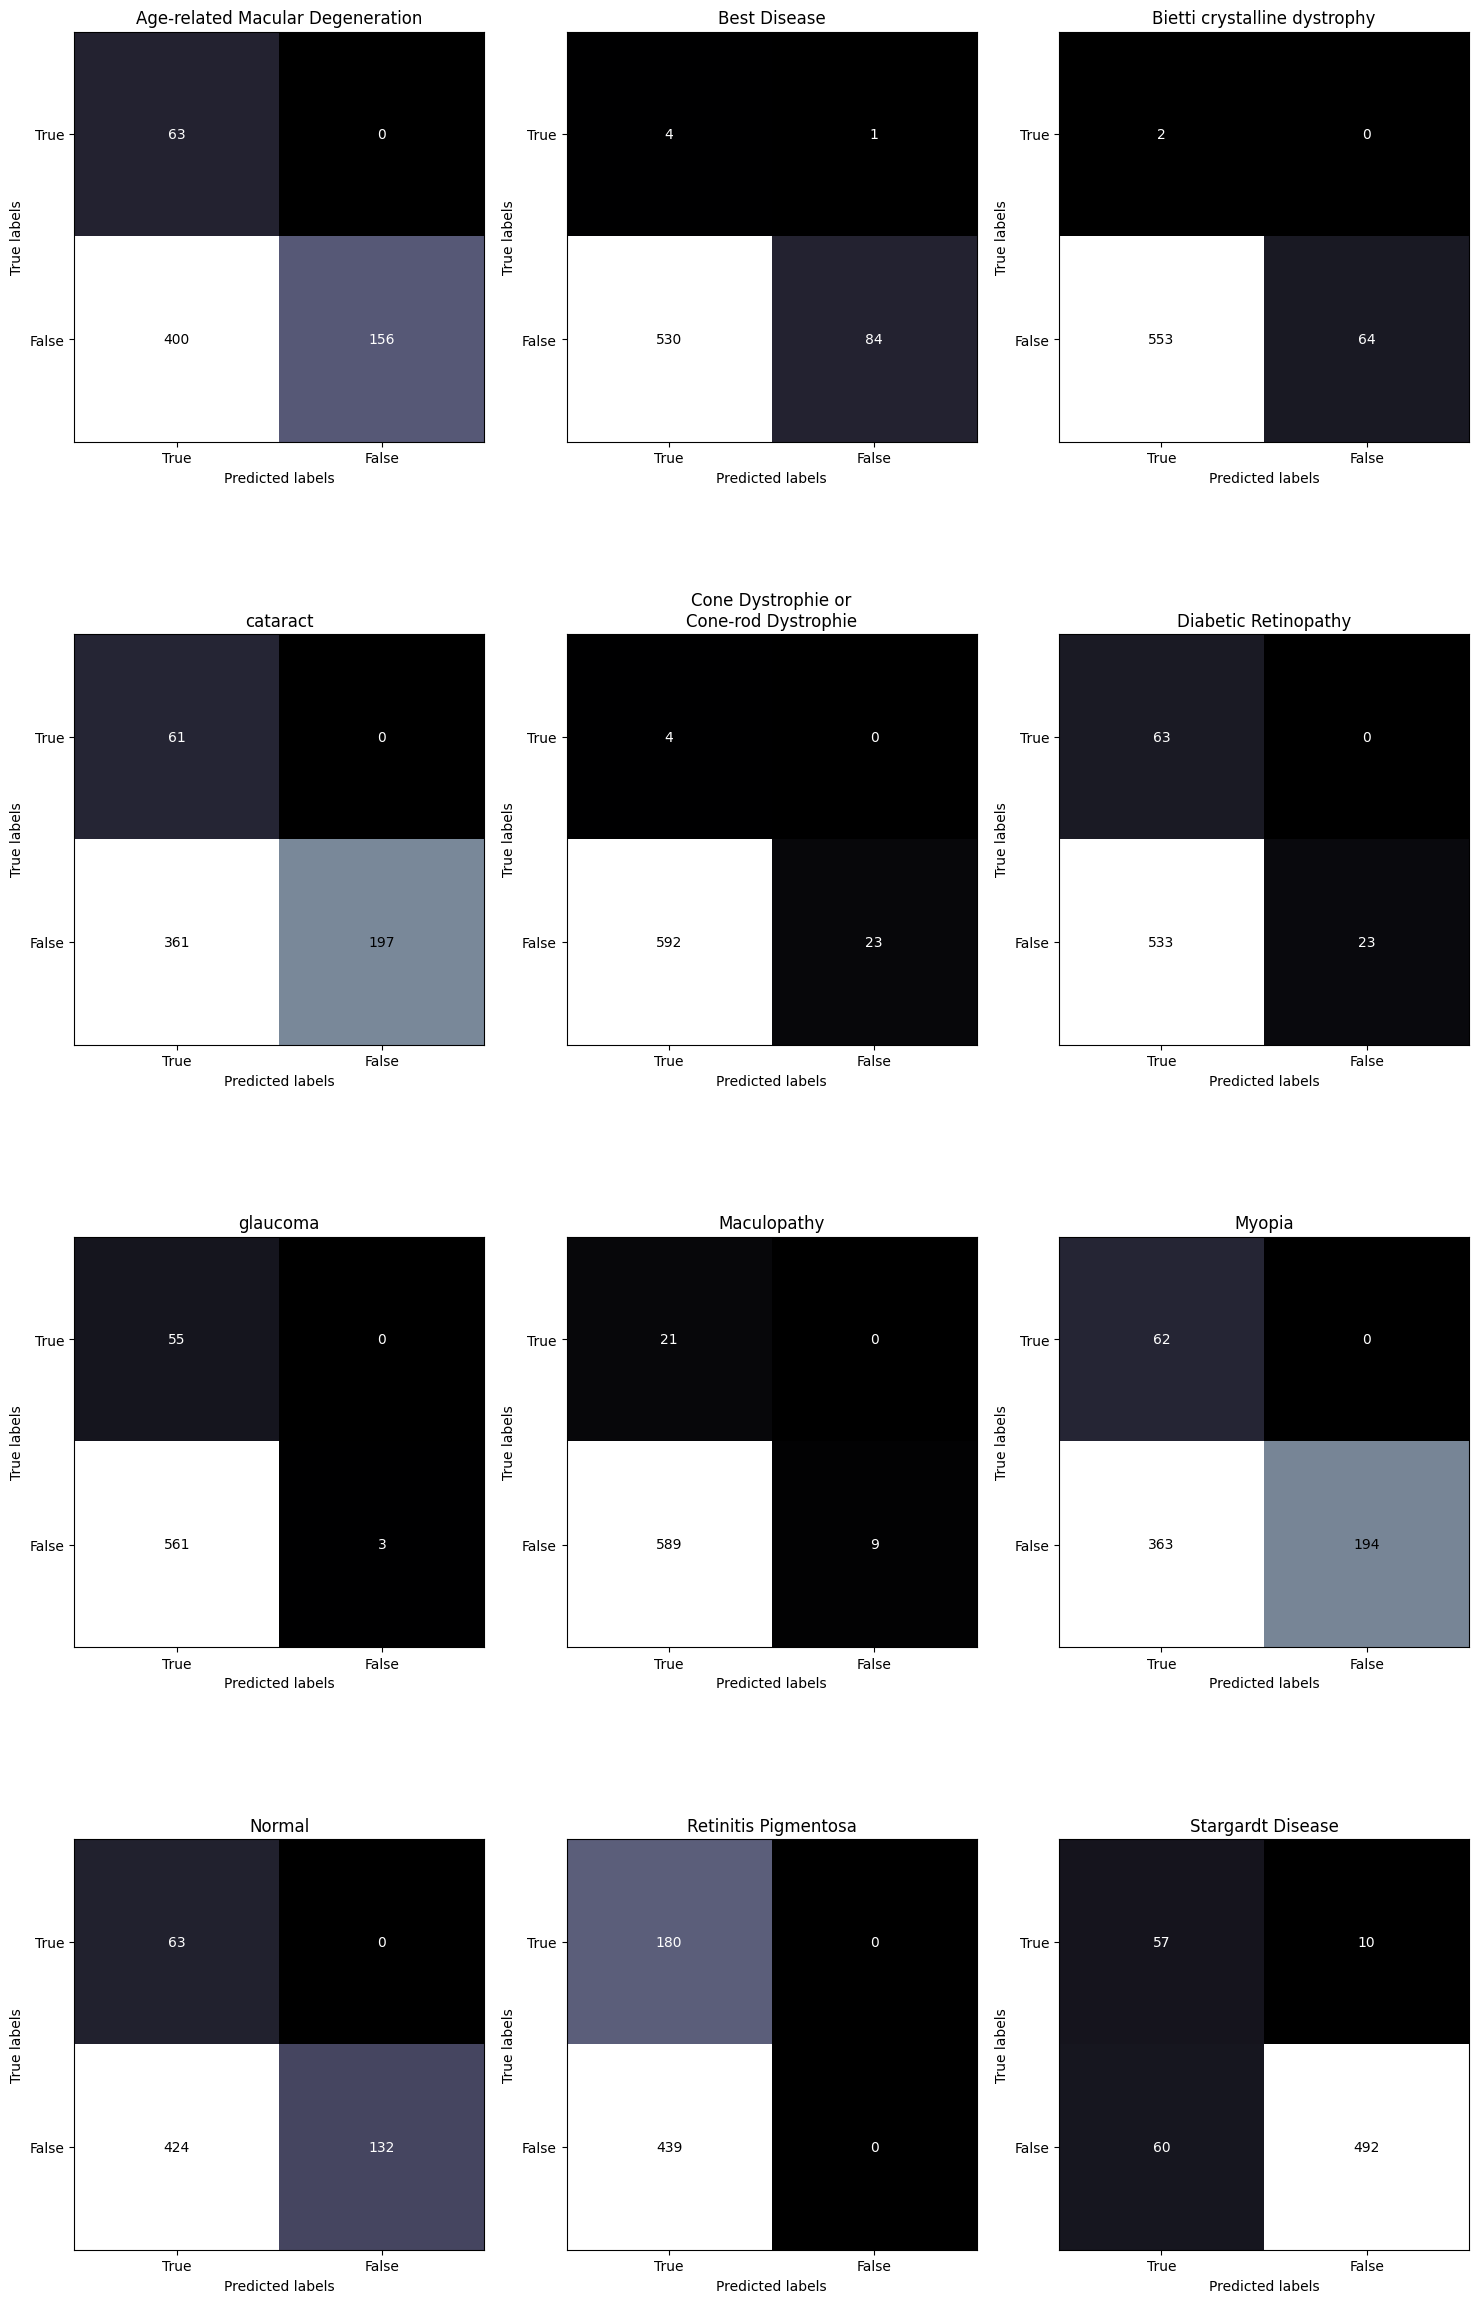

In [ ]:
y_pred_cm = torch.sigmoid(y_pred) >best_thresholds
#calculate the confusion matrices on the test set
confusion_matrices = multilabel_confusion_matrix(y_true, y_pred_cm)
flipped_confusion_matrices = np.flip(confusion_matrices, axis=-1)
flipped_confusion_matrices = np.flip(flipped_confusion_matrices, axis=-2)
#plot the confusion matrices, one for each class, 3 per row
n_cols = 3
n_rows = int(np.ceil(len(labels_to_encode) / n_cols))
fig, axes = plt.subplots(n_rows, n_cols, figsize=(18, 30))
axes = axes.flatten()
for i, ax in enumerate(axes):
    #use the confusion matrix to plot the confusion matrix
    cm = confusion_matrices[i]
    disp = ConfusionMatrixDisplay(confusion_matrix=flipped_confusion_matrices[i], display_labels=['True', 'False'])
    #turn off color bar

    disp.plot(ax=ax, colorbar=False, cmap='bone')
    title = labels_to_encode[i]
    #split the title into multiple lines if it is too long
    if title.count(' ') > 2:
        #split every 3rd space
        title = title.split(' ')
        title = [' '.join(title[i:i+3]) for i in range(0, len(title), 3)]
        title = '\n'.join(title)
    ax.set_title(title)
    ax.set_xlabel('Predicted labels')
    ax.set_ylabel('True labels')